In [7]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

dc = datacube.Datacube()

In [8]:
#define area of interest
query = {
    
        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
    
    #Pambula wetlands
'y': (-36.924, -36.988),
'x': (149.848, 149.925), 
    
'time': ('2018-01-01', '2018-04-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [9]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

<xarray.Dataset>
Dimensions:          (time: 15, x: 313, y: 320)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-04-25T23:44:07
  * y                (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x                (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 251 294 327 321 336 ... 354 345 336 344
    blue             (time, y, x) int16 175 222 245 239 253 ... 250 251 247 242
    green            (time, y, x) int16 297 327 340 304 326 ... 201 207 202 194
    red              (time, y, x) int16 190 225 258 261 304 ... 119 113 111 113
    nir              (time, y, x) int16 2713 2529 2356 2074 2123 ... 94 93 90 85
    swir1            (time, y, x) int16 1002 1167 1232 1054 1165 ... 45 52 41 39
    swir2            (time, y, x) int16 454 483 552 497 594 ... 33 34 40 32 27
Attributes:
    crs:      EPSG: 3577

In [10]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)

#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 15, y: 320, x: 313)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True, False, ...,  True,  True],
        [ True, False, ..., False, False],
        ...,
        [False, False, ...,  True, False],
        [False, False, ...,  True,  True]],

       ...,

       [[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-04-25T23:44:07
  * y        (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x        

In [11]:
#apply Mask
Masked_lst8_data = data_lst8.where(good_quality)

In [13]:
TC_wetness = ((0.0315*Masked_lst8_data['blue'])+(0.2021*Masked_lst8_data['green'])+
              (0.3102*Masked_lst8_data['red'])+(0.1594*Masked_lst8_data['nir'])+
              (-0.6806*Masked_lst8_data['swir1'])+(-0.6109*Masked_lst8_data['swir2']))

In [17]:
TC_Greeness = ((-0.1603*Masked_lst8_data['blue'])+(-0.2819*Masked_lst8_data['green'])+
              (-0.4934*Masked_lst8_data['red'])+(0.7940*Masked_lst8_data['nir'])+
              (-0.0002*Masked_lst8_data['swir1'])+(-0.1446*Masked_lst8_data['swir2']))

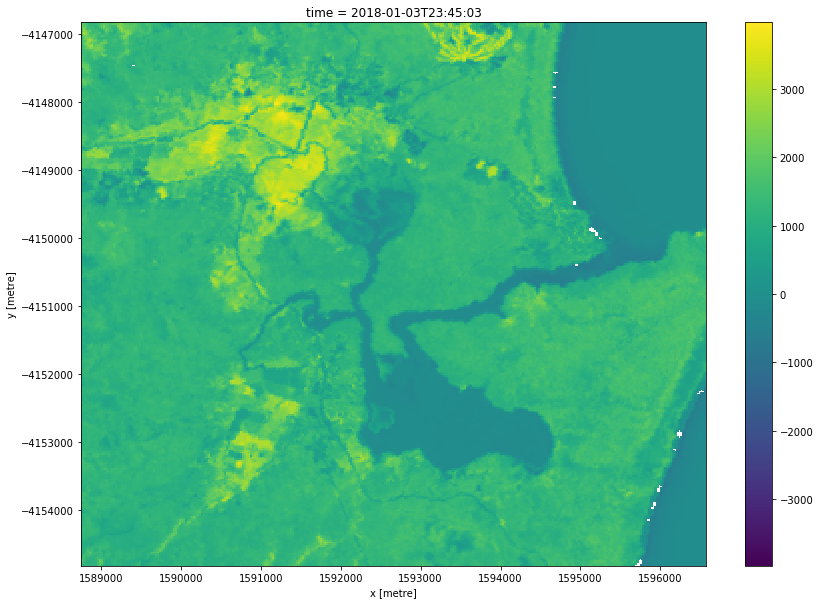

In [18]:
TC_Greeness.isel(time=0).plot(cmap='viridis', figsize =(14,10))